# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

references
* arichitecture picture: https://arxiv.org/pdf/1703.03906.pdf
* tutorial: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
* data source: http://www.statmt.org/wmt14/translation-task.html
* data source2: http://www.manythings.org/anki/

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, Iterator, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from decoder import Decoder
from encoder import Encoder
from attention import Attention
from train import evaluation
# others
import argparse
from argparser import get_parser
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.cuda.current_device()
# USE_CUDA = False
# DEVICE = -1

## Prepare Loader

In [3]:
lang1 = 'fra'
lang2 = 'eng'
config = get_parser(lang1, lang2)
SOURCE = Field(tokenize=str.split, use_vocab=True, init_token="<s>", eos_token="</s>", lower=True, 
                   include_lengths=True, batch_first=True)
TARGET = Field(tokenize=str.split, use_vocab=True, init_token="<s>", eos_token="</s>", lower=True, 
               batch_first=True)

train_data, valid_data, test_data = \
        TabularDataset.splits(path=config.PATH, format='tsv', train=config.TRAIN_FILE, \
                              validation=config.VALID_FILE, test=config.TEST_FILE, \
                              fields=[('so', SOURCE), ('ta', TARGET)])

SOURCE.build_vocab(train_data)
TARGET.build_vocab(train_data)

test_loader = BucketIterator(test_data, batch_size=config.BATCH, device=DEVICE,
                              sort_key=lambda x: len(x.so), sort_within_batch=True, repeat=False)

# vocaburary
V_so = len(SOURCE.vocab)
V_ta = len(TARGET.vocab)

In [4]:
def get_word_counts(lang):
    words_count = []
    for k, v in lang.vocab.freqs.items():
        words_count.append((k, v))
    words_count = sorted(words_count, key=lambda x: x[1], reverse=True)
    return words_count

In [5]:
def plot_word_counts(counts):
    x, y = zip(*counts)
    idxes = np.arange(1, len(counts)+1)
    print("top 10 words: {}".format(x[:10]))
    plt.bar(idxes, np.log(np.array(y)+1), 1)
    plt.show()

top 10 words: ('.', 'je', '?', 'est', 'vous', 'a', 'pas', 'il', 'de', 'ne')


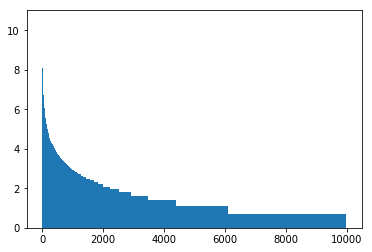

In [6]:
source_words_count = get_word_counts(SOURCE)
plot_word_counts(source_words_count)

top 10 words: ('.', 'i', 'you', '?', 'a', 'it', 'is', 's', 't', 'the')


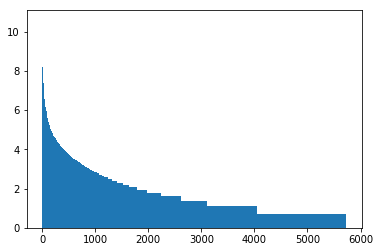

In [7]:
source_words_count = get_word_counts(TARGET)
plot_word_counts(source_words_count)

In [8]:
print('train data: {}, valid_data: {}, test_data: {}'.format(len(train_data), len(valid_data), len(test_data)))
print('source language vocab: {}, target language vocab: {}'.format(V_so, V_ta))

train data: 47500, valid_data: 1250, test_data: 1250
source language vocab: 9989, target language vocab: 5737


## architecture

![](./pics/encoder_decoder_att.png)

---

## Build Networks

In [9]:
def build(config):
    enc = Encoder(V_so, config.EMBED, config.HIDDEN, config.NUM_HIDDEN, bidrec=True)
    dec = Decoder(V_ta, config.EMBED, 2*config.HIDDEN, hidden_size2=config.HIDDEN2, \
                  sos_idx=SOURCE.vocab.stoi['<s>'], method=config.METHOD)
    if USE_CUDA:
        enc = enc.cuda()
        dec = dec.cuda()

    loss_function = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi['<pad>'])
    return enc, dec, loss_function

## Load model parameters & test

In [13]:
for i in range(1, 2):
    enc, dec, loss_function = build(config)
    enc.eval()
    dec.eval()
    
    enc_model_path = './data/model/{}-{}{}.enc'.format(lang1, lang2, i)
    dec_model_path = './data/model/{}-{}{}.dec'.format(lang1, lang2, i)
    
    enc.load_state_dict(torch.load(enc_model_path))
    dec.load_state_dict(torch.load(dec_model_path))
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 1 | test_losses: 1.8627828896045684


## Visualize Attention

In [14]:
# borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

In [15]:
enc, dec, loss_function = build(config)
i = 1
enc_model_path = './data/model/{}-{}{}.enc'.format(lang1, lang2, i)
dec_model_path = './data/model/{}-{}{}.dec'.format(lang1, lang2, i)

enc.load_state_dict(torch.load(enc_model_path))
dec.load_state_dict(torch.load(dec_model_path))

Source :  je veux le faire pour toi .
Truth :  i want to do it for you .
Prediction :  i want to do you all you .


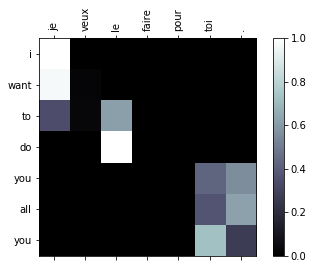

In [21]:
enc.eval()
dec.eval()

test = random.choice(test_data)
source_sentence = test.so
target_sentence = test.ta

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

output, hidden = enc(s, [s.size(1)])
pred, attn = dec.decode(hidden, output, [s.size(1)])
pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]


print('Source : ', ' '.join(source_sentence))
print('Truth : ', ' '.join(target_sentence))
print('Prediction : ', ' '.join(pred_sentence))

if USE_CUDA:
    attn = attn.cpu()

show_attention(source_sentence, pred_sentence, attn.data[1:-1])